In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms

module_path = os.path.abspath(os.path.join('..'))
abs_path = "/content/drive/MyDrive/atml"
sys.path.append(abs_path+"/models")
sys.path.append(abs_path+"/train")
sys.path.append(abs_path+"/datasets")

# Fix seed 
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [19]:
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDataset, AddUniformNoise, AddGeneratedNoise, NoiseGeneratorNet
from train import train_control_vae, test_control_vae
from loss import loss_control_vae
from control_vae import ControlVAEDSprites

In [37]:
# transform = None
# transform_needs_latents = False

# transform = AddUniformNoise(-.1, .1)
# transform_needs_latents = False

transform = AddGeneratedNoise(abs_path + "/datasets/noisenet.pth", device)
transform_needs_latents = True

In [20]:
dataset = CustomDSpritesDataset(load_dsprites(abs_path + "/datasets/dsprites.npz", False))

In [21]:
# n_imgs = 50000
# #indices = torch.randperm(dataset.size(0))[:n_imgs]
# indices = torch.randperm(dataset.size(0))
# dataset = dataset[indices]

In [22]:
data_train, data_test = train_test_random_split(dataset.idx, 0.8)

In [23]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [24]:
beta_controller_args = {
    'C' : 0.5,
    'C_max' : 8,
    'C_step_val' : 0.15,
    'C_step_period' : 5000,
    'Kp' : 0.01,
    'Ki' : -0.001,
    'Kd' : 0.0
}

In [25]:
model = ControlVAEDSprites(beta_controller_args)
model.to(device)

ControlVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [26]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

In [38]:
train_loss, recon_loss, kl_div = train_control_vae(model, 50, train_loader, optimizer, 'bernoulli', 
                                                  dataset, transform, transform_needs_latents, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 151.22978170795574, recon loss: 120.00121226741209, kl div: 1.0008364634640101


In [39]:
test_control_vae(model, test_loader, 'bernoulli', 
                dataset, transform, transform_needs_latents, device = device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


117.85193599263827

In [ ]:
torch.save(model, '/content/drive/MyDrive/atml/controlvae_epoch50_lr1e2_Cmax8.dat')
np.save('/content/drive/MyDrive/atml/controlvae_epoch50_lr1e2_Cmax8_train_loss.npy', train_loss)
np.save('/content/drive/MyDrive/atml/controlvae_epoch50_lr1e2_Cmax8_recon_loss.npy', recon_loss)
np.save('/content/drive/MyDrive/atml/controlvae_epoch50_lr1e2_Cmax8_kl_divs.npy', kl_div)

In [ ]:
model = torch.load('/content/drive/MyDrive/atml/controlvae_epoch500_lr1e2_Cmax12.dat')
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

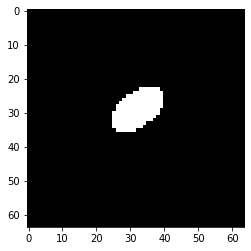

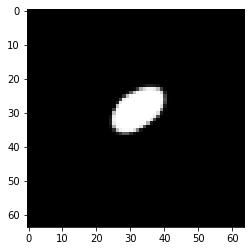

In [ ]:
index = 198964
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()